# Часть 1. Приоритизация гипотез

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import warnings

In [2]:
# откроем файл с гипотезами
hypothesis = pd.read_csv('/datasets/hypothesis.csv')

In [3]:
# приводим столбцы к нижнему регистру
hypothesis.set_axis(hypothesis.columns.str.lower(), axis='columns', inplace=True)

In [4]:
pd.set_option('max_colwidth', 150)

Используем фреймворки ICE и RICE для приоритизации гипотез. Данные фреймворки рассчитываются по следующим формулам:


$$ICE = \frac{Impact * Confidence}{Efforts}$$

$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

In [5]:
hypothesis['ice'] = (hypothesis['impact'] * hypothesis['confidence'] /
                     hypothesis['efforts']).round().astype('int')
hypothesis.sort_values(by='ice', ascending=False)[['hypothesis', 'ice']]

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1


In [6]:
hypothesis['rice'] = (hypothesis['reach'] *  hypothesis['impact'] * hypothesis['confidence'] /
                     hypothesis['efforts']).round().astype('int')
hypothesis.sort_values(by='rice', ascending=False)[['hypothesis', 'rice']]

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40
8,"Запустить акцию, дающую скидку на товар в день рождения",16
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3


Во фреймворке ICE самой приоритетной гипотезой является запуск акции, дающей скидку на товар в день рождения. Но в RICE эта гипотеза ниже, т.к. параметр Reach для неё равен единице - это изменение затронет очень малое количество пользователей. Гипотеза добавления блоков рекомендаций товаров на сайт интернет магазина во фреймворке RICE, наоборот, более приоритетна, чем в ICE, потому что затронет большую долю пользователей (по сути всех, кто пользуется интернет-магазином). Гипотезы 0, 7, 6 в обоих фреймворках имеют высокий приоритет.

# Часть 2. Анализ A/B теста

### 2.1 Предобработка данных

Подготовим данные к анализу. Проверим данные на соответствие нужному формату, отсутствие пропущенных значений и дубликатов.

In [7]:
orders = pd.read_csv('/datasets/orders.csv')

In [8]:
visitors = pd.read_csv('/datasets/visitors.csv')

In [9]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [10]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [12]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [13]:
# приведем даты в пригодный для работы с датами формат
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')

In [14]:
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')

In [15]:
# проверка строк на пропущенные значения
orders.isna().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

In [16]:
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

In [17]:
# проверка строк на дубликаты
orders.duplicated().sum()

0

In [18]:
visitors.duplicated().sum()

0

Дополнительно проверим, есть ли среди пользователей те, кто попал в обе группы.

In [19]:
orders_a = orders[orders['group'] == 'A']
orders_b = orders[orders['group'] == 'B']
orders_a['visitorId'].isin(orders_b['visitorId']).sum()

89

Сразу 89 пользователей попали в обе группы. Удалим их, чтобы не искажать результаты теста.

In [20]:
# выделяем значения столбца с посетителями в отдельные множества
orders_a_set = set(orders_a['visitorId'])
orders_b_set = set(orders_b['visitorId'])

# ищем пересечения этих множеств
orders_intersected = orders_a_set.intersection(orders_b_set)

# оставляем те строки в таблице, где значения столбца с 
# посетителями не равны значеням, найденным в пересечениях множеств
orders = orders[~orders.visitorId.isin(orders_intersected)]

In [21]:
# дополнительно проверяем, уменьшилось ли количество строк в датафрейме
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1016 non-null int64
visitorId        1016 non-null int64
date             1016 non-null datetime64[ns]
revenue          1016 non-null int64
group            1016 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


Проверим столбец выручки на неположительные значения.

In [22]:
(orders['revenue'] <= 0).sum()

0

Данные готовы к анализу.

### 2.2 Кумулятивные метрики

Построим график кумулятивной выручки, среднего чека и его относительного изменения, конверсии и её относительного изменения.

In [23]:
# создадим датафрейм со всеми датами, в которые пользователи двух 
# групп совершали покупки
dates_and_groups = orders[['date', 'group']].drop_duplicates()

In [24]:
# создадим датафрейм, в котором на каждую дату будут выведены
# накопленное количество покупателей, накопленная выручка и
# накопленное количество заказов отдельно для каждой группы
orders_aggregated = dates_and_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'],
                                           orders['group'] == x['group'])].agg({
'date': 'max',
'group': 'max',
'transactionId': 'nunique',
'visitorId': 'nunique',
'revenue': 'sum'}), axis=1).sort_values(by=['date','group'])

orders_aggregated = orders_aggregated.rename(columns={
    'transactionId': 'number_of_transactions',
    'visitorId':'number_of_buyers'})

In [25]:
# разделим полученный датафрейм на два разных, в соответствии с группой пользователей
# и оставим в нём нужные для дальнейшего анализа столбцы
cumulative_revenue_A = orders_aggregated.loc[orders_aggregated.loc[:, 'group'] == 'A'][['date', 'number_of_transactions',
                                                                                        'revenue']]
cumulative_revenue_B = orders_aggregated.loc[orders_aggregated.loc[:, 'group'] == 'B'][['date', 'number_of_transactions',
                                                                                        'revenue']]

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


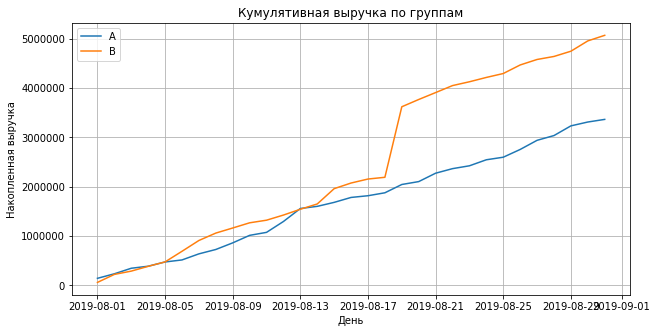

In [26]:
# отобразим кумулятивную выручку по группам на графике
plt.figure(figsize=(10, 5))

plt.plot(cumulative_revenue_A['date'],
         cumulative_revenue_A['revenue'],
         label='A')

plt.plot(cumulative_revenue_B['date'],
         cumulative_revenue_B['revenue'], 
         label='B')

plt.xlabel('День')
plt.ylabel('Накопленная выручка')
plt.title('Кумулятивная выручка по группам')
plt.grid()
plt.legend()
plt.show()

Резкий перелом для графика группы B говорит о том, что на значение выручки могут влиять аномальные значения (в данном случае - заказы, сделанные на слишком большую сумму).

Взглянем на график кумулятивного среднего чека

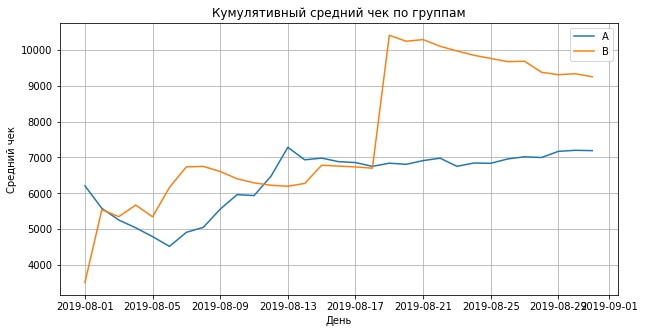

In [27]:
# отображаем кумулятивный средний чек по группам на графике
plt.figure(figsize=(10, 5))

plt.plot(cumulative_revenue_A['date'],
         cumulative_revenue_A['revenue']/cumulative_revenue_A['number_of_transactions'],
         label='A')

plt.plot(cumulative_revenue_B['date'], 
         cumulative_revenue_B['revenue']/cumulative_revenue_B['number_of_transactions'],
         label='B')
plt.xlabel('День')
plt.ylabel('Средний чек')
plt.title('Кумулятивный средний чек по группам')
plt.grid()
plt.legend()
plt.show()

На данном графике также видны переломы. Особенно сильный перелом для группы B виден в том же месте, что и на предыдущем графике. И средний чек, и выручка в один день скакнули очень сильно. Ещё одно подтверждение того, что в определенный период был сделан заказ на очень крупную сумму.

Построим график относительного изменения кумулятивного среднего чека

In [28]:
# соединяем два датафрейма
merged_cumulative_revenue = cumulative_revenue_A.merge(cumulative_revenue_B, on='date',
                                                       how='left', suffixes=['A', 'B'])

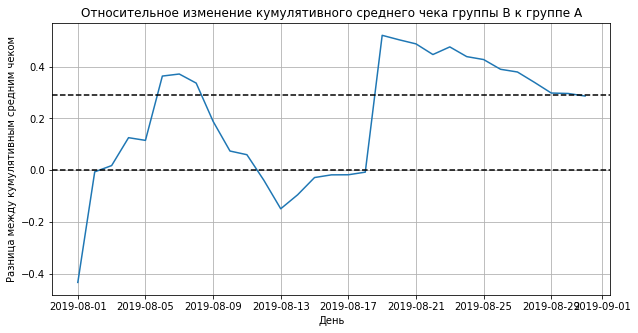

In [29]:
# визуализируем относительное изменение кумулятивного среднего чека группы B к группе A
plt.figure(figsize=(10, 5))

plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB'] / 
                                             merged_cumulative_revenue['number_of_transactionsB']) / 
                                             (merged_cumulative_revenue['revenueA'] / 
                                             merged_cumulative_revenue['number_of_transactionsA']) - 1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.29, color='black', linestyle='--')

plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('День')
plt.ylabel('Разница между кумулятивным средним чеком')
plt.grid()
plt.show()

Значения переламываются в нескольких точках, в том числе снова в той, где резкий перелом был замечен на прошлых графиках.

Построим график кумулятивной конверсии из посетителей в покупки.

In [30]:
# создаем датафрейм, в котором отразим накопленное количество посетителей
# на каждую дату по группам
visitors_aggregated = dates_and_groups.apply(
lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
'date': 'max',
'group': 'max',
'visitors': 'sum'}), axis=1).sort_values(by=['date','group'])

In [31]:
# соединяем все накопленные данные
cumulative_data = orders_aggregated.merge(visitors_aggregated, on=['date', 'group'])

In [32]:
# делим количество покупок на количество посетителей. Это и будет 
# конверсией из посетителей в покупки
cumulative_data['conversion'] = cumulative_data['number_of_transactions'] / cumulative_data['visitors']

In [33]:
# делим все накопленные данные по группам
cumulative_data_A = cumulative_data.loc[cumulative_data.loc[:, 'group'] == 'A']
cumulative_data_B = cumulative_data.loc[cumulative_data.loc[:, 'group'] == 'B']

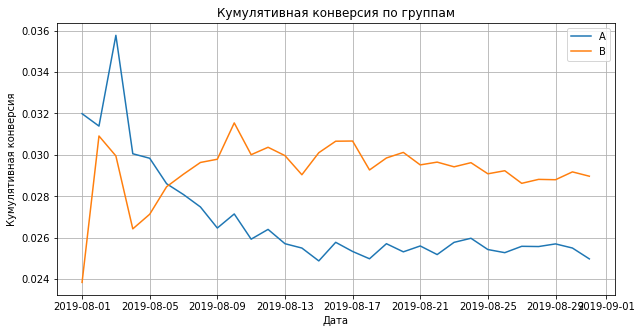

In [34]:
# визуализируем кумулятивную конверсию по группам на графике
plt.figure(figsize=(10, 5))

plt.plot(cumulative_data_A['date'], cumulative_data_A['conversion'], label='A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['conversion'], label='B')

plt.title('Кумулятивная конверсия по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
plt.grid()
plt.legend()
plt.show()

Кумулятивная конверсия из посетителей в покупки также выше у В.

In [35]:
# оставляем в отдельном датафрейме только накопленные конверсии 
merged_cumulative_conversions = cumulative_data_A[['date', 'conversion']].merge(cumulative_data_B[['date', 'conversion']],
                                                                               on='date',
                                                                               suffixes=['A', 'B'])

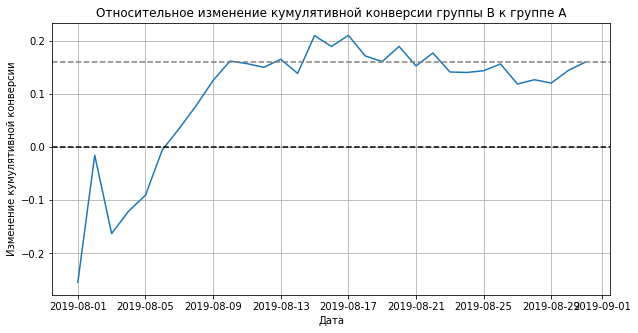

In [36]:
# визуализируем относительное изменение кумулятивной конверсии
# группы B к группе A
plt.figure(figsize=(10, 5))

plt.plot(merged_cumulative_conversions['date'],
         (merged_cumulative_conversions['conversionB']/merged_cumulative_conversions['conversionA']-1))

plt.title('Относительное изменение кумулятивной конверсии группы В к группе А')
plt.xlabel('Дата')
plt.ylabel('Изменение кумулятивной конверсии')
plt.grid()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.16, color='gray', linestyle='--')
plt.show()

Относительная разница зафиксировалась на уровне в 16%.

### 2.3 Построение точечных графиков

Построим точечный график количества заказов по пользователям

In [37]:
orders_by_users = orders.groupby('visitorId')['transactionId'].nunique()\
    .reset_index().sort_values(by='transactionId', ascending=False)

In [38]:
orders_by_users.head()

,visitorId,transactionId
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3


На точечном графике посмотрим, сколько заказов совершали разные пользователи.

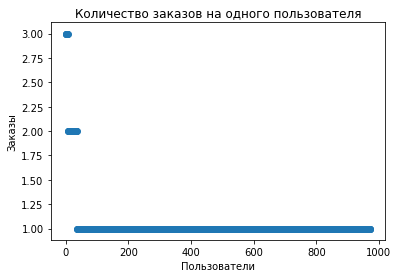

In [39]:
x_values = pd.Series(range(0, len(orders_by_users)))
plt.scatter(x_values, orders_by_users['transactionId'])
plt.title('Количество заказов на одного пользователя')
plt.xlabel('Пользователи')
plt.ylabel('Заказы')
plt.show()

Подавляющее большинство пользователей сделали только 1 заказ. 

Посчитаем перцентили.

In [40]:
np.percentile(orders_by_users['transactionId'], [90, 95, 99])

array([1., 1., 2.])

Всего лишь около 1% пользователей сделали больше 1 заказа. Однако максимальное количество заказов, которое сделал пользователь не превышает 3. Так что этот 1% не исказит результаты исследования.

На другом точечном графике посмотрим, сколько выручки приносит один заказ.

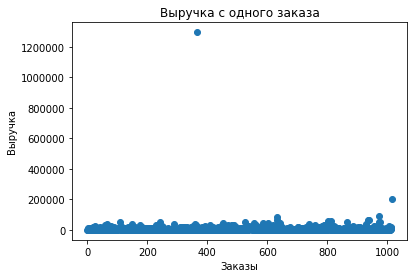

In [41]:
x_values2 = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values2, orders['revenue'])
plt.title('Выручка с одного заказа')
plt.xlabel('Заказы')
plt.ylabel('Выручка')
plt.show()

Основная масса заказов сделана на небольшую сумму, однако есть очень сильно выбивающиеся значения.

Посмотрим на перцентили.

In [42]:
np.percentile(orders['revenue'], [90, 95, 99])

array([17990., 26785., 53904.])

95% пользователей сделали заказ на менее, чем 26785 рублей. В то же время есть 1% пользователей, которые сделали заказ на более чем 53904 рубля. На графике видно, что есть заказ и на более чем 1 млн рублей. Он может существенно исказить результаты теста. Поставим границу максимального заказа на отметке 26785 рублей.

### 2.4 Расчёт статистической значимости по "сырым" и "очищенным" данным

Посчитаем статистическую значимость различий в конверсии между группами по "сырым" данным.

In [43]:
# создаём датафреймы для двух групп, где в каждом отражены
# подневное и накопленное количество посетителей на определенную дату
visitors_a_daily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitor_per_date_a']

visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: \
        visitors_a_daily[visitors_a_daily['date'] <= x['date']]\
            .agg({
                'date':'max',
                'visitor_per_date_a':'sum'}), axis=1)

visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

In [44]:
visitors_b_daily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitor_per_date_b']

visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: \
        visitors_b_daily[visitors_b_daily['date'] <= x['date']]\
            .agg({
                'date':'max',
                'visitor_per_date_b':'sum'}), axis=1)

visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

In [45]:
# создаём датафреймы для двух групп, где в каждом отражены подневное и накопленное
# количество заказов и подневное и накопленное количество выручки на определенную дату
orders_a_daily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False).agg({
                                        'transactionId':'nunique', 
                                        'revenue':'sum'})

orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

orders_a_cummulative = orders_a_daily.apply(
    lambda x: \
        orders_a_daily[orders_a_daily['date'] <= x['date']]\
            .agg({
                'date':'max',
                'orders_per_date_a':'sum',
                'revenue_per_date_a':'sum'}), axis=1).sort_values(by=['date'])

orders_a_cummulative.columns = ['date', 'orders_cummulative_a', 'revenue_cummulative_a']

In [46]:
orders_b_daily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False).agg({
                                          'transactionId':'nunique',
                                          'revenue':'sum'})

orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_b_cummulative = orders_b_daily.apply(
    lambda x: \
        orders_b_daily[orders_b_daily['date'] <= x['date']]\
            .agg({
                'date':'max',
                'orders_per_date_b':'sum',
                'revenue_per_date_b':'sum'}), axis=1).sort_values(by=['date'])

orders_b_cummulative.columns = ['date', 'orders_cummulative_b', 'revenue_cummulative_b']

In [47]:
# соединяем все датафреймы с подневными и накопленными показателями
# количества заказов, выручки и посетителей
data = orders_a_daily.merge(orders_b_daily, on='date', how='left')\
    .merge(orders_a_cummulative, on='date', how='left')\
    .merge(orders_b_cummulative, on='date', how='left')\
    .merge(visitors_a_daily, on='date', how='left')\
    .merge(visitors_b_daily, on='date', how='left')\
    .merge(visitors_a_cummulative, on='date', how='left')\
    .merge(visitors_b_cummulative, on='date', how='left')

In [48]:
data.head()

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitor_per_date_a,visitor_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


In [49]:
# создаём два датафрейма для каждой группы, в которых
# отразим количество заказов, которое сделал один пользователь
orders_by_users_a = orders[orders['group']=='A']\
    .groupby('visitorId', as_index=False)\
    .agg({'transactionId':'nunique'})

orders_by_users_a.columns = ['visitorId', 'orders']

orders_by_users_b = orders[orders['group']=='B']\
    .groupby('visitorId', as_index=False)\
    .agg({'transactionId':'nunique'})

orders_by_users_b.columns = ['visitorId', 'orders'] 

In [50]:
# создадим списки, где пользователям, которые ничего не заказали
# будет соответствовать нулевое значение
sample_a = pd.concat([orders_by_users_a['orders'], 
                      pd.Series(0, index=np.arange(data['visitor_per_date_a'].sum() - len(orders_by_users_a['orders'])),
                                name='orders')], axis=0) 

sample_b = pd.concat([orders_by_users_b['orders'], 
                      pd.Series(0, index=np.arange(data['visitor_per_date_b'].sum() - len(orders_by_users_b['orders'])),
                                name='orders')], axis=0) 

Нулевая гипотеза: конверсия из посетителей в покупки не имеет статистически значимых различий в двух группах

Альтернативная гипотеза: конверсия из посетителей в покупки статистически различается в двух группах.

In [51]:
# проверяем статистическую значимость различий в конверсиях
# и точечное значение конверсий в разных группах
print("{0:.5f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))
print("{0:.3f}".format((data['orders_per_date_b'].sum()/data['visitor_per_date_b'].sum())/
                       (data['orders_per_date_a'].sum()/data['visitor_per_date_a'].sum())-1))

0.00551
0.160


Нулевая гипотеза отвергнута. В конверсии из посетителей в покупки по "сырым" данным есть статистически значимые различия, так как значение p-value менее 5%. Разницу между конверсиями отражает и точечное значение: у группы B она на 16% больше.

Нулевая гипотеза: средний чек не имеет статистических различий в двух группах.

Альтернативная гипотеза: средний чек имеет статистические различия в двух группах.

In [52]:
print("{0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'],
                                          orders[orders['group']=='B']['revenue'])[1]))
print("{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.415
0.287


Нулевая гипотеза не отвергнута. P-value по "сырым" данным сильно выше 5%, значит, по логике статистически значимых различий в среднем чеке двух групп нет, однако точечная оценка среднего чека показывает, что средний чек в группе B на 28.7% выше, чем в группе A.

Очистим данные от аномальных пользователей. Напомним, что аномальными пользователями были признаны те, кто совершил заказ на строго более чем 26785 рублей.

In [53]:
abnormal_users = orders[orders['revenue'] > 26785]['visitorId']

In [54]:
sample_a_filtered = pd.concat([orders_by_users_a[np.logical_not(orders_by_users_a['visitorId'].isin(abnormal_users))]['orders'], 
                               pd.Series(0, index=np.arange(data['visitor_per_date_a'].sum() - len(orders_by_users_a['orders'])), 
                                         name='orders')], axis=0)

sample_b_filtered = pd.concat([orders_by_users_b[np.logical_not(orders_by_users_b['visitorId'].isin(abnormal_users))]['orders'], 
                             pd.Series(0, index=np.arange(data['visitor_per_date_b'].sum() - len(orders_by_users_b['orders'])), 
                                       name='orders')],axis=0) 

Нулевая гипотеза: конверсия из посетителей в покупки не имеет статистически значимых различий в двух группах

Альтернативная гипотеза: конверсия из посетителей в покупки статистически различается в двух группах.

In [55]:
print("{0:.3f}".format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
print("{0:.3f}".format(sample_b_filtered.mean()/sample_a_filtered.mean()-1)) 

0.008
0.156


Нулевая гипотеза отвергнута. Данные по конверсии из посетителей в покупатели после очищения от аномальных пользователей изменились незначительно.

Нулевая гипотеза: средний чек не имеет статистических различий в двух группах.

Альтернативная гипотеза: средний чек имеет статистические различия в двух группах.

In [56]:
print("{0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'])[1]))

print("{0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'].mean() - 1)) 

0.371
-0.053


Нулевая гипотеза не отвергнута. Статистическая значимость, так же, как и для аномальных данных, не достигнута, так как p-value намного больше 5%. Однако точечная оценка среднего чека существенно изменилась. Теперь средний чек A на 5.3% больше, чем средний чек в группе B. Аномальные пользователи сильно влияли на результаты A/B теста. Окончательный вывод не изменился: статистически значимых различий в среднем чеке между группами A и B нет.

### 2.5 Выводы по результатам A/B теста

Имеющиеся факты:

1) и по "сырым", и по "очищенным" данным выявлены статистические значимые различия в конверсии из посетителей в покупки;

2) и по "сырым", и по "очищенным" данным не было выявлено статистически значимых различий в значении среднего чека;

3) график кумулятивной конверсии показывает, что у группы B она на 16% выше, чем у группы A;

По результатам теста принято решение: остановить тест и зафиксировать победу группы B.